In [129]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import sys
import tables.group
from operator import itemgetter


import macd
import pandas.io.data as web
import matplotlib.pyplot as plt
import multiprocessing as mp
%matplotlib inline
ff='depth16'
filename='source/'+ff+'.hd5'
path='data/'+ff+'_r.hd5'
print pd.__version__

0.17.1


In [130]:

h5 = pd.HDFStore(filename, 'r')
    
def getGroups(h5):
    groups = {}
    for i in h5.items():
        groups[i[0]]=(i[0],i[1])
    return groups

def getTables(group):
    group=group[1]
    tables={}
    for c in group._v_children:
        tables[c]=group._f_get_child(c)
    return tables

def getIndex(group):
    return getTables(group)['axis1'][:]

def getColumns(group):
    return getTables(group)['axis0'][:]

def getColumn(group,name):
    columns = getColumns(group)
    cidx=0
    while cidx<len(columns) and columns[cidx] != name:
        cidx+=1 
        
    if cidx >= len(columns):
        return None
    
    return getTables(group)['block0_values'][:][:]

def dedupIdx(idx):
    if len(idx) <=0:
        return idx

    idx=idx*1000
    p=idx[0]
    c=0
    for i in range(1,len(idx)):
        idxo=idx[i]
        if idx[i]==p:
            idx[i]+=c
            c+=1
        else:
            c=1
        p=idxo
    return idx
        
def getDataFrame(group):
    idx = getIndex(group)
    idx=pd.to_datetime(idx,unit='ms')
    #idx=dedupIdx(idx)
    columns = getColumns(group)
    tables= getTables(group)['block0_values']
    dt = pd.DataFrame(tables[:][:],columns=columns,index=idx)
    return dt

def getDataFrames(h5):
    groups =  getGroups(h5)

    keys = sorted(groups.keys())
    dfs={}
    for k in keys:
        df = getDataFrame(groups[k])
        dfs[k]=df
    return dfs
        



        

In [131]:
dfs=getDataFrames(h5)
for d in dfs:
    print d

/BTC_ETH_kraken_yobit
/BTC_ETH_kraken
/BTC_ETH_yobit_bleutrade
/BTC_ETH_bitflyer_yobit
/BTC_ETH_kraken_bitcoinind
/BTC_ETH_poloniex_bitflyer
/BTC_ETH_bitflyer_kraken
/BTC_ETH_bitflyer_bitcoinind
/BTC_ETH_yobit_bittrex
/BTC_ETH_bittrex_yobit
/BTC_ETH_kraken_poloniex
/BTC_ETH_bitcoinind_kraken
/BTC_ETH_bleutrade_bitcoinind
/BTC_ETH_bittrex_poloniex
/BTC_ETH_bleutrade_yobit
/BTC_ETH_poloniex_yobit
/BTC_ETH_poloniex_bleutrade
/BTC_ETH_bitflyer_bleutrade
/BTC_ETH_bitflyer_poloniex
/BTC_ETH_bitcoinind_bleutrade
/BTC_ETH_bitfinex_bitcoinind
/BTC_ETH_bitcoinind_yobit
/BTC_ETH_yobit
/BTC_ETH_bleutrade
/BTC_ETH_bitcoinind_poloniex
/BTC_ETH_bittrex_bitcoinind
/BTC_ETH_bitflyer
/BTC_ETH_bitcoinind_bitfinex
/BTC_ETH_poloniex_bitcoinind
/BTC_ETH_bittrex_bleutrade
/BTC_ETH_yobit_poloniex
/BTC_ETH_bitflyer_bittrex
/BTC_ETH_bitcoinind_bittrex
/BTC_ETH_bittrex
/BTC_ETH_bitcoinind
/BTC_ETH_poloniex
/BTC_ETH_yobit_kraken
/BTC_ETH_yobit_bitcoinind
/BTC_ETH_bleutrade_bitfinex
/BTC_ETH_bleutrade_bittrex
/BTC

In [202]:
figsize=(20, 10)

def plotTrades1(pair='/BTC_ETH',exchanges=[],exclude=[],dtFrom=None,dtTo=None,rtLim=300.0,btcLim=0.0):
    #from :'2016-05-14 02:00:00'
    #to '2016-05-14 02:12:00'
    dfs=getDataFrames(h5)
    fig, axs1 = plt.subplots(1,1,figsize=figsize)
    fig, axs2 = plt.subplots(1,1,figsize=figsize)
    fig, axs3 = plt.subplots(1,1,figsize=figsize)   
    for n in dfs.keys():
        cols = list(dfs[n].columns.values)
        if len([c for c in cols if c == 'profitBtc']) <=0:
            continue
        
        if not n.startswith(pair):
            continue
        f=[e for e in exchanges if n.find(e)!=-1]
        if len(exchanges)!=0 and len(f)==0:
            continue

        f=[e for e in exclude if n.find(e)==-1]
        if len(exclude)!=0 and len(f)==0:
            continue
        
        df=dfs[n].query('rt1 < '+str(rtLim)).query('rt2<'+str(rtLim))
        #btc=df['profitBtc'].loc[dtFrom:dtTo]

        prof=df['profit'].loc[dtFrom:dtTo]
        bal=df['balanceBtc'].loc[dtFrom:dtTo]
        btc=(prof-1.0)*(1-bal)

        #q1=df['q1'].loc[dtFrom:dtTo]
        #q2=df['q2'].loc[dtFrom:dtTo]
        rt1=df['rt1'].loc[dtFrom:dtTo]
        rt2=df['rt2'].loc[dtFrom:dtTo]
        
        btc1=btc[btc>btcLim]
        rt1=rt1[btc>btcLim]
        rt2=rt2[btc>btcLim]
        
        if len(btc1) > 0:
            btc1.plot(ax=axs1,figsize=figsize,label=n+'_btc',legend=True,marker='o',ls='')
            #q1.plot(ax=axs2,figsize=figsize,label=n+'_q1',legend=True,marker='o',ls='')
            #q2.plot(ax=axs2,figsize=figsize,label=n+'_q2',legend=True,marker='o',ls='')
            rt1.plot(ax=axs2,figsize=figsize,label=n+'_rt1',legend=True,marker='o',ls='')
            rt2.plot(ax=axs3,figsize=figsize,label=n+'_rt2',legend=True,marker='o',ls='')


def plotTrades2(pair='/BTC_ETH',exchanges=[],exclude=[],dtFrom=None,dtTo=None,rtLim=300.0,btcLim=0.0):
    #from :'2016-05-14 02:00:00'
    #to '2016-05-14 02:12:00'
    dfs=getDataFrames(h5)
    fig, axs4 = plt.subplots(1,1,figsize=figsize)
    fig, axs5 = plt.subplots(1,1,figsize=figsize)
    fig, axs6 = plt.subplots(1,1,figsize=figsize)    
    for n in dfs.keys():
        cols = list(dfs[n].columns.values)
        if len([c for c in cols if c == 'profitBtc']) <=0:
            continue
        
        if not n.startswith(pair):
            continue
        f=[e for e in exchanges if n.find(e)!=-1]
        if len(exchanges)!=0 and len(f)==0:
            continue

        f=[e for e in exclude if n.find(e)==-1]
        if len(exclude)!=0 and len(f)==0:
            continue
            
        df=dfs[n].query('rt1 < '+str(rtLim)).query('rt2<'+str(rtLim))
        #btc=df['profitBtc'].loc[dtFrom:dtTo]

        prof=df['profit'].loc[dtFrom:dtTo]
        bal=df['balanceBtc'].loc[dtFrom:dtTo]
        btc=(prof-1.0)*(1-bal)
        nt=df['numTrades'].loc[dtFrom:dtTo]

        #q1=df['q1'].loc[dtFrom:dtTo]
        #q2=df['q2'].loc[dtFrom:dtTo]
        
        btc1=btc[btc>btcLim]
        nt=nt[btc>btcLim]

        
        if len(btc1) > 0:
            #q1.plot(ax=axs2,figsize=figsize,label=n+'_q1',legend=True,marker='o',ls='')
            #q2.plot(ax=axs2,figsize=figsize,label=n+'_q2',legend=True,marker='o',ls='')
            nt.plot(ax=axs4,figsize=figsize,label=n+'_nt',legend=True,marker='o',ls='')
            prof.plot(ax=axs5,figsize=figsize,label=n+'_prof',legend=True,marker='o',ls='')
            bal.plot(ax=axs6,figsize=figsize,label=n+'_bal',legend=True,marker='o',ls='')
            
#plotTrades(exchanges=['kraken'],dtFrom='2016-05-14 04:20:25')
#plotTrades(exchanges=['poloniex'],dtFrom='2016-05-15 19:11:00',dtTo='2016-05-15 19:41:00')


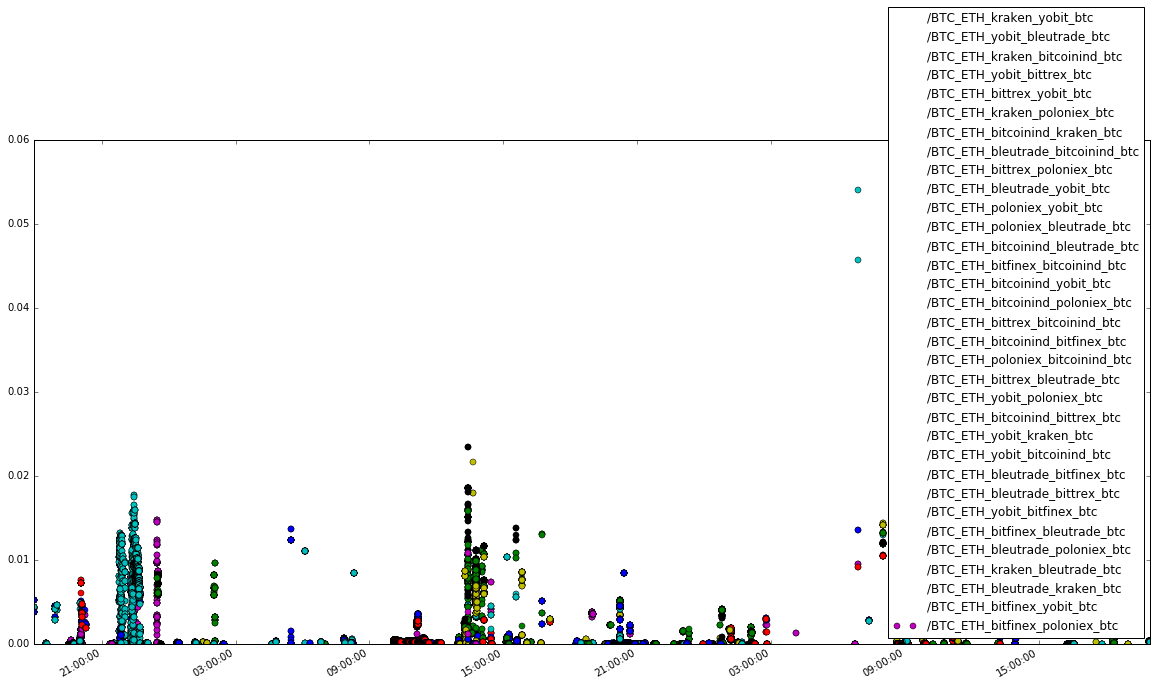

In [ ]:
plotTrades1(rtLim=1000,exchanges=[],exclude=['bitflyer'])


In [ ]:
plotTrades2(rtLim=1000,exchanges=[],exclude=['bitflyer'])

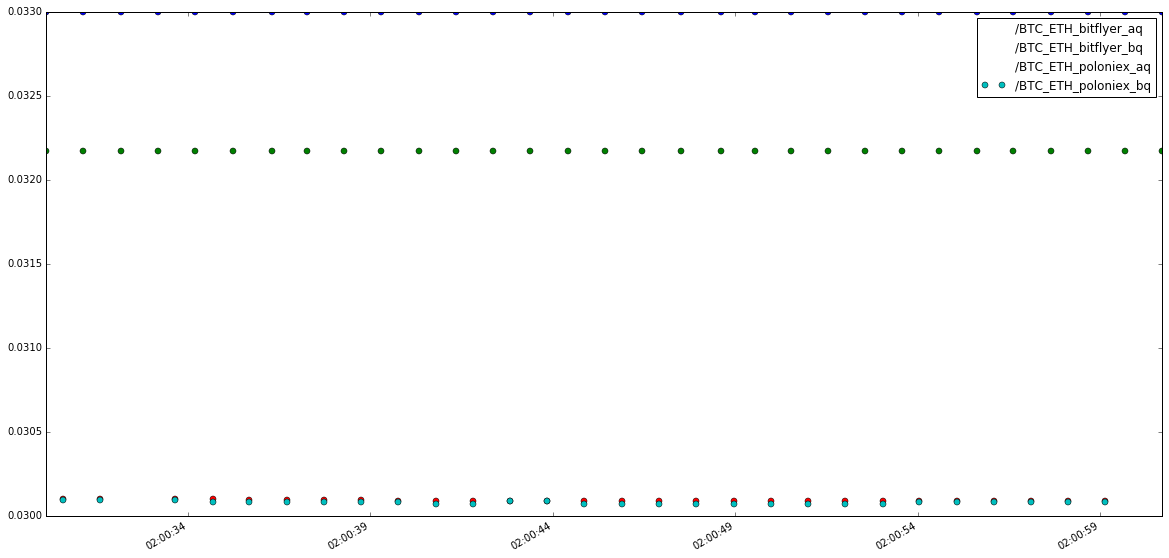

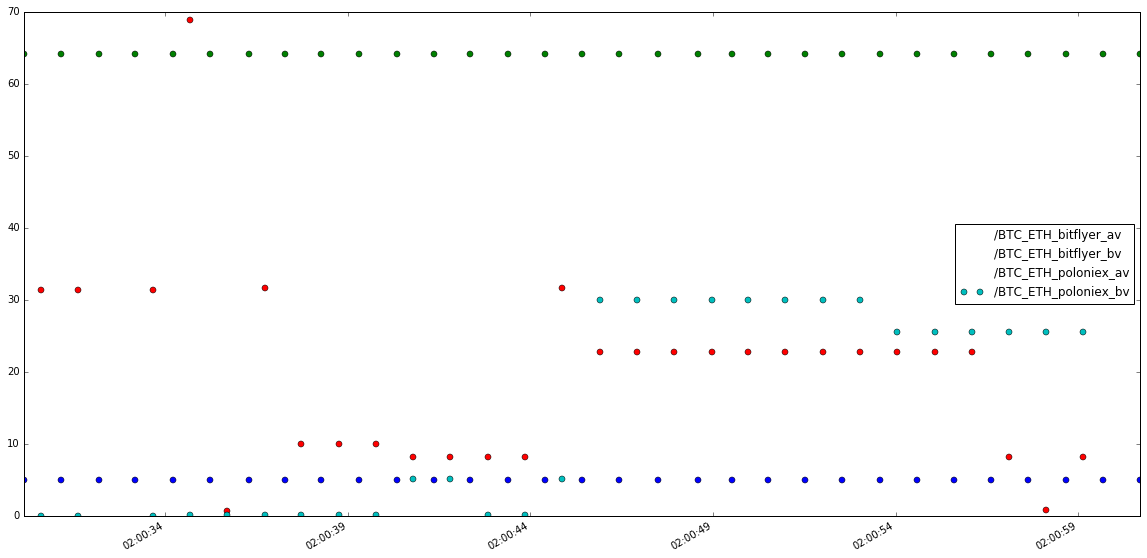

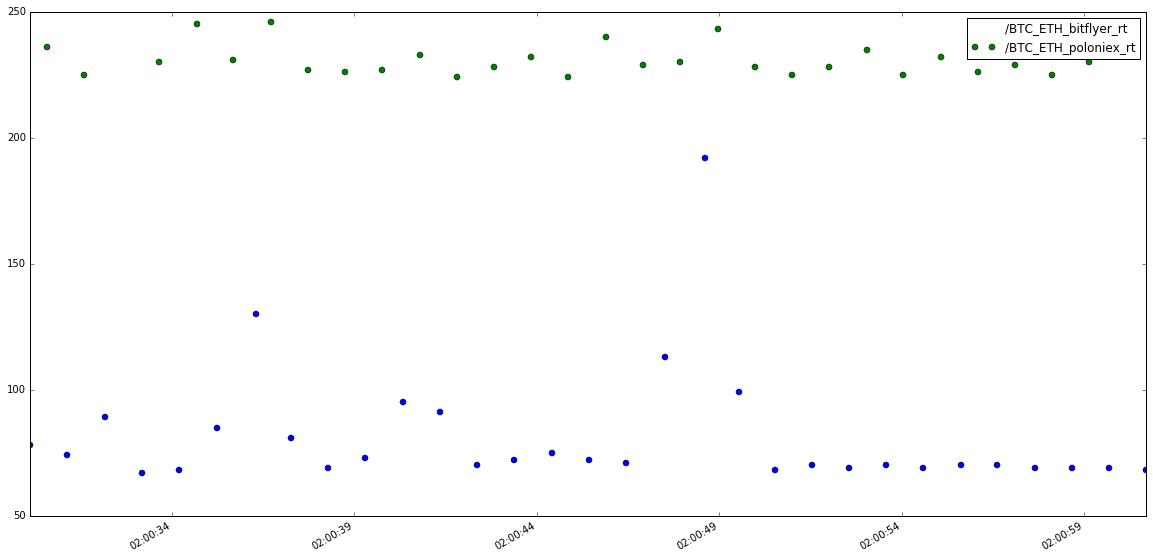

In [115]:
def plotQuotes(pair='/BTC_ETH',exchanges=[],dtFrom=None,dtTo=None,rtLim=300.0):
    #from :'2016-05-14 02:00:00'
    #to '2016-05-14 02:12:00'
    dfs=getDataFrames(h5)
    fig, axs1 = plt.subplots(1,1,figsize=figsize)
    fig, axs2 = plt.subplots(1,1,figsize=figsize)
    fig, axs3 = plt.subplots(1,1,figsize=figsize)
    for n in dfs.keys():
        cols = list(dfs[n].columns.values)
        if len([c for c in cols if c == 'aq']) <=0:
            continue
        
        if not n.startswith(pair):
            continue
        f=[e for e in exchanges if n.find(e)!=-1]
        if len(exchanges)!=0 and len(f)==0:
            continue
        df=dfs[n].query('rt < '+str(rtLim))
        aq=df['aq'].loc[dtFrom:dtTo]
        bq=df['bq'].loc[dtFrom:dtTo]
        av=df['av'].loc[dtFrom:dtTo]
        bv=df['bv'].loc[dtFrom:dtTo]
        
        rt=df['rt'].loc[dtFrom:dtTo]
        
        if aq.size >0:
            aq.plot(ax=axs1,figsize=figsize,label=n+'_aq',legend=True,marker='o',ls='')
            bq.plot(ax=axs1,figsize=figsize,label=n+'_bq',legend=True,marker='o',ls='')
            av.plot(ax=axs2,figsize=figsize,label=n+'_av',legend=True,marker='o',ls='')
            bv.plot(ax=axs2,figsize=figsize,label=n+'_bv',legend=True,marker='o',ls='')
            rt.plot(ax=axs3,figsize=figsize,label=n+'_rt',legend=True,marker='o',ls='')
            
#plotQuotes(exchanges=['kraken'],dtFrom='2016-05-14 04:20:25')
#plotQuotes(exchanges=['poloniex'],dtFrom='2016-05-15 19:11:00',dtTo='2016-05-15 19:41:00')
plotQuotes(rtLim=250,exchanges=['poloniex','bitflyer'],dtFrom='2016-05-21 02:00:30',dtTo='2016-05-21 02:01:00')

In [ ]:
dfs=getDataFrames(h5)
btc={}
for n in dfs.keys():
    df=dfs[n]
    btc[n]=(df['profitBtc'].mean(),df['profitBtc'].size)
    
btc=sorted(btc.items(), key=itemgetter(1))

for n in btc:
    print n

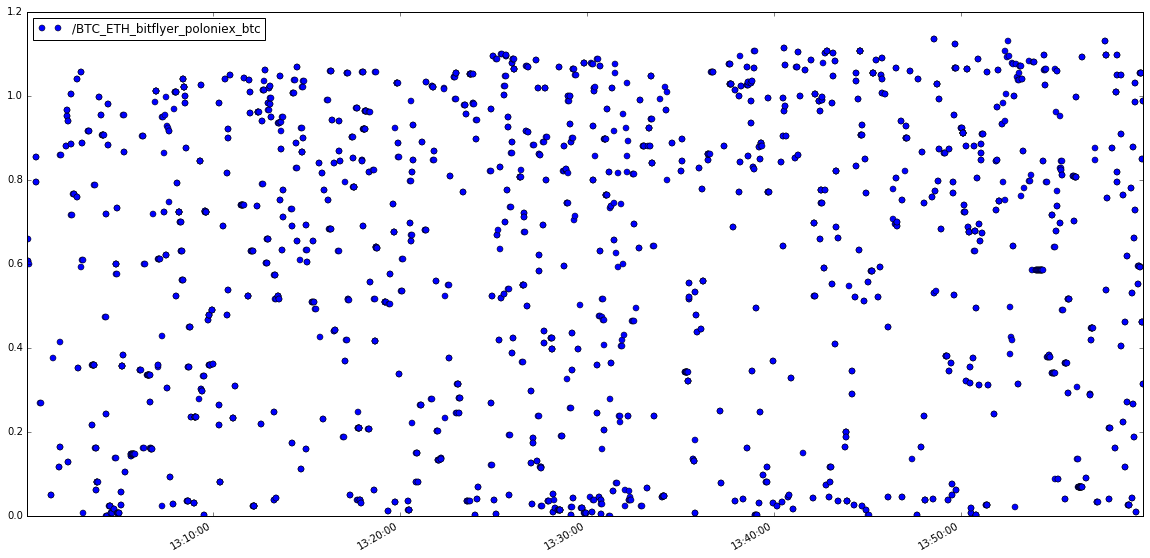

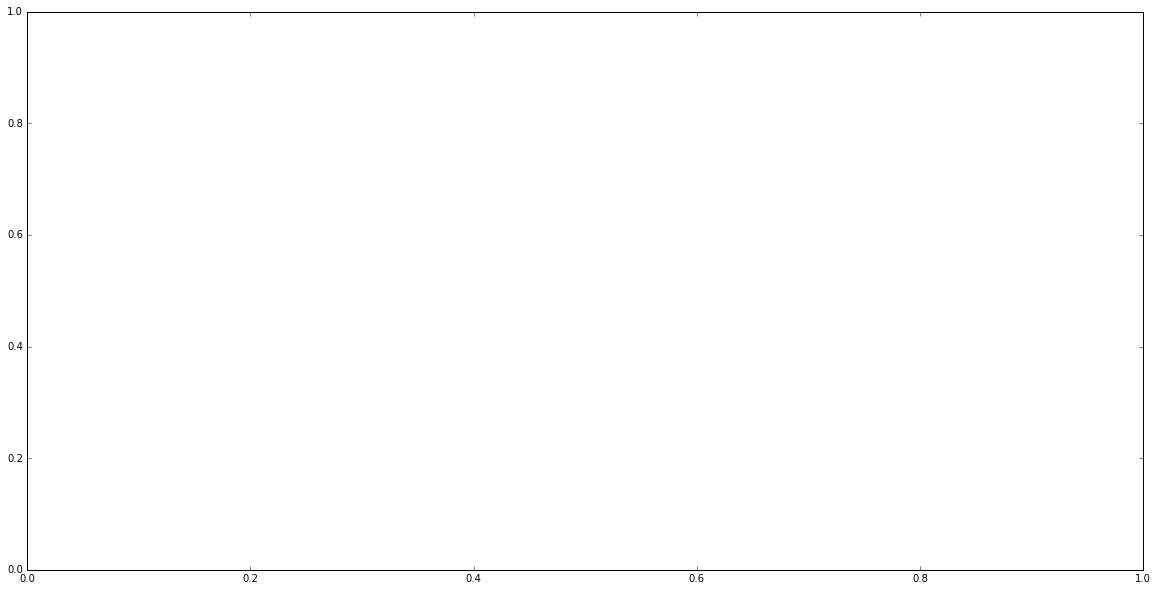

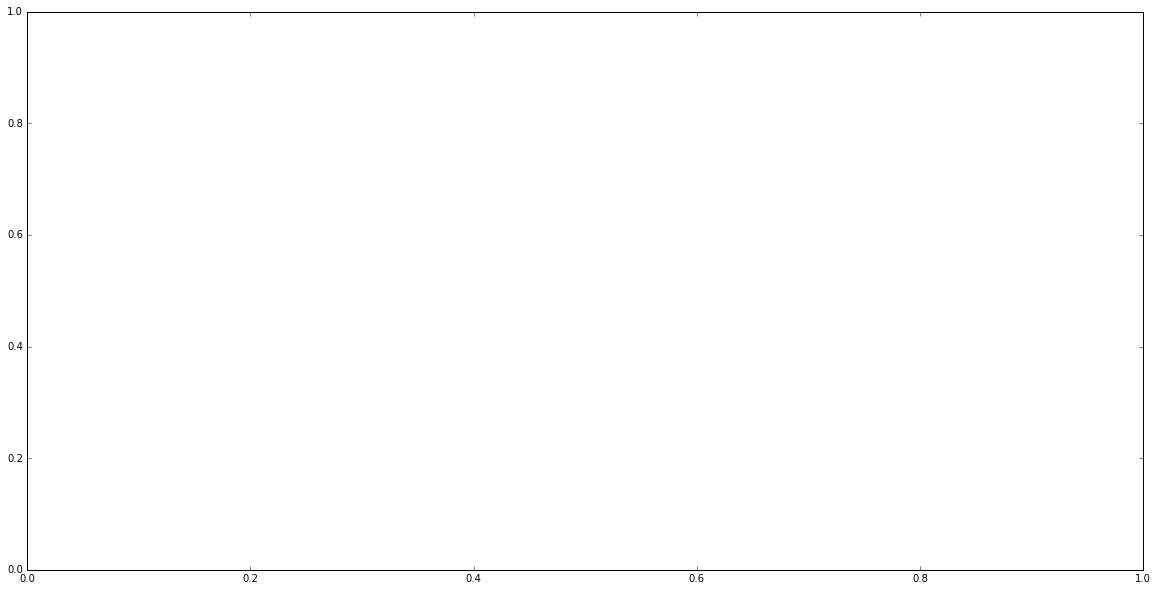

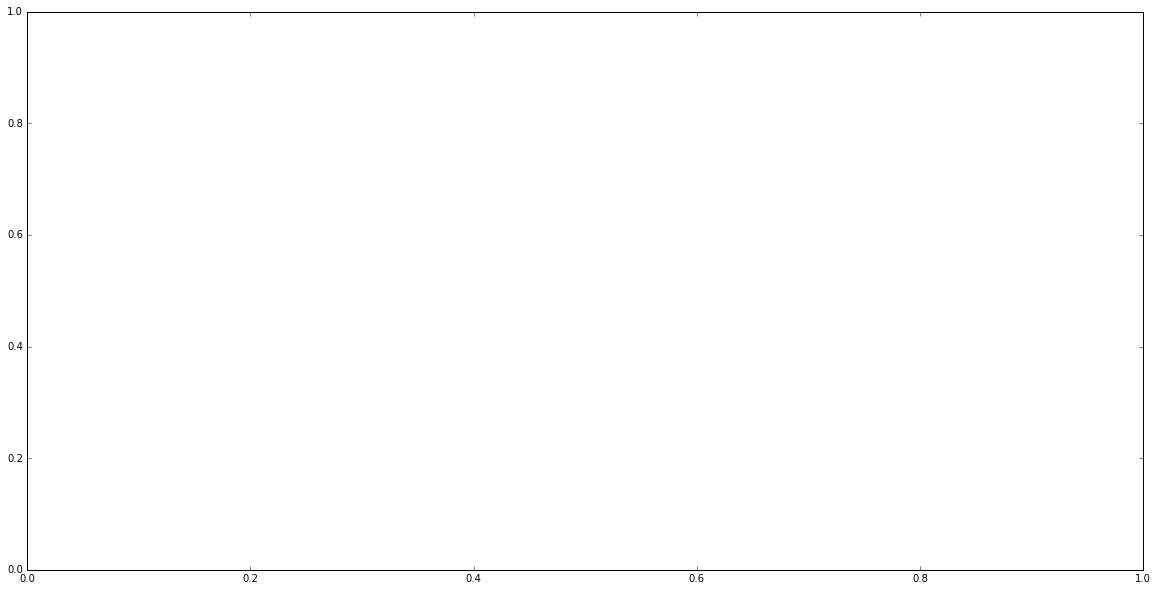

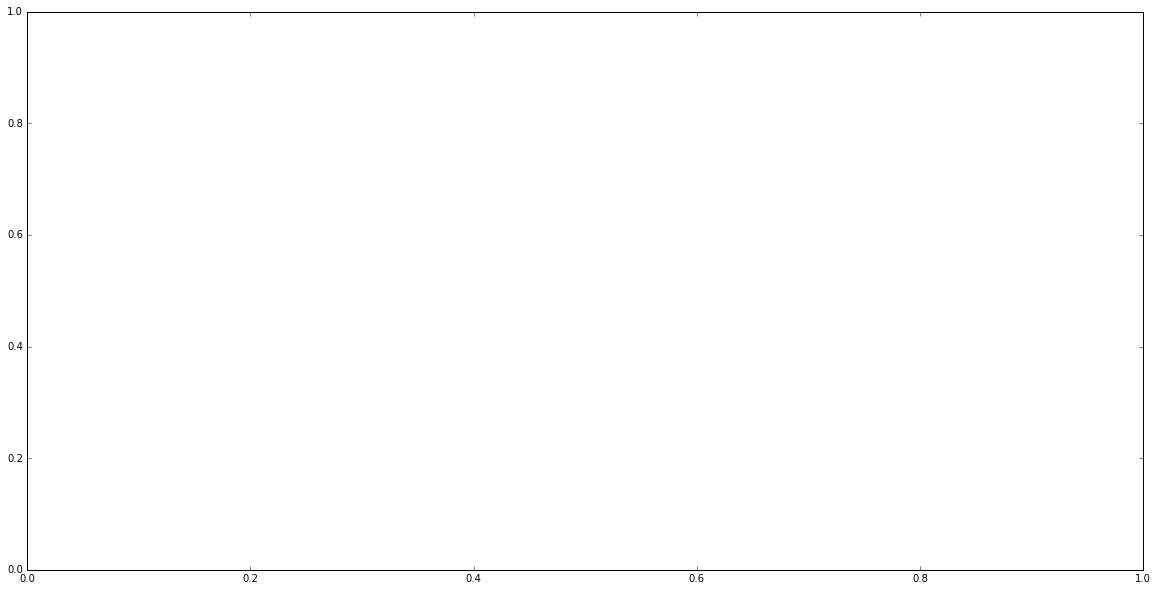

In [100]:
pd.to_datetime(1463796030000,unit='ms')

Timestamp('2016-05-21 02:00:30')